Author: Alexis Laignelet

Date: 06/09/19

# Import packages

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn

# Build the dataset

In [2]:
# Define the parameters

nb = 50
mu = 0
sigma = 0.1
x_min = -2
x_max = 2

In [3]:
# Build the true function

def true_function(x):
    return (x-2)* np.sin(2*x)

In [4]:
x = np.linspace(x_min, x_max, nb)

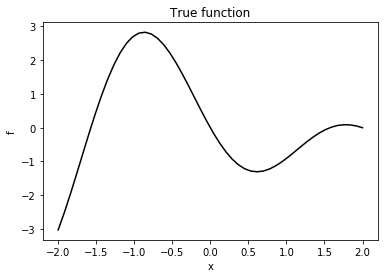

In [5]:
plt.plot(x, true_function(x), color='black')
plt.xlabel('x')
plt.ylabel('f')
plt.title('True function');

In [6]:
# Define disturbance

np.random.seed(1)
eps = np.random.normal(mu, sigma, nb)

In [7]:
# Define points y

y = true_function(x) + eps

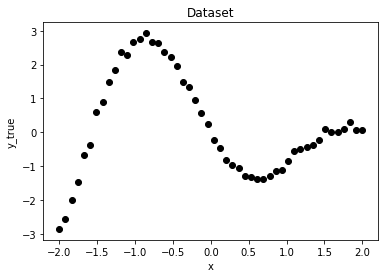

In [8]:
plt.scatter(x, y, color = 'black')
plt.xlabel('x')
plt.ylabel('y_true')
plt.title('Dataset');

# Define the model

This correspond to a conventional neural network, using SGD.

In [9]:
class NeuralNet(torch.nn.Module):
  
    def __init__(self, D_in, H1, H2, D_out):
        super(NeuralNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H1)
        self.linear2 = torch.nn.Linear(H1, H2)
        self.linear3 = torch.nn.Linear(H2, D_out)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

In [10]:
def SGD(nb_iter, lr):
    torch.manual_seed(0)
    
    # Empty array to store values
    train_loss = np.array([])
    
    # Define loss function
    loss_fn = torch.nn.MSELoss(reduction='sum')
    
    # Instanciate the model
    model = NeuralNet(D_in, H1, H2, D_out)
    
    # Define the optimiser
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for t in range(nb_iter):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x)

        # Compute loss
        loss = loss_fn(y_pred, y)

        # Store values
        train_loss = np.append(train_loss, loss.detach().numpy())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return train_loss

# Define proxy neural network

In [11]:
class activation_function(nn.Module):
    def __init__(self):
        super(activation_function, self).__init__()

    def forward(self, x):
        return F.relu(x)

In [12]:
class NeuralFBSNN(torch.nn.Module):
    def __init__(self, list_layers):
        super(NeuralFBSNN, self).__init__()
        
        # Empty list to store layers
        self.layers = []

        numLayers = len(list_layers)
        
        # Add the differents layers: neurons and activation function
        for i in range(numLayers - 2):
            self.layers.append(nn.Linear(list_layers[i], list_layers[i+1]))
            self.layers.append(activation_function())
        self.layers.append(nn.Linear(list_layers[-2], list_layers[-1]))

    def forward(self, x):
        # Empty list to store intermediate values
        ai = []
        zi = []
        y = x
        
        # Compute a forward pass and store values before (zi) and after activation function (ai)
        for i in range(len(self.layers)):
            y = self.layers[i](y)
            if (type(self.layers[i]) == nn.Linear) and (i < len(self.layers)-1):
                zi.append(y)
            elif i < len(self.layers)-1:
                ai.append(y)                
        return ai, zi, y

In [13]:
def solve_implicit(A, Y, Z, beta):
    # Provide the exact solution of the proximal
    AA = A.t().mm(A)
    I = torch.eye(A.size(1)).type_as(A)
    A_tilde = AA + beta * I
    b_tilde = A.t().mm(Y) + beta*Z
    X, _ = torch.solve(b_tilde, A_tilde)
    
    return X

In [14]:
def FBSNN(tau, nb_iter, lr):
    torch.manual_seed(0)
    
    # Empty array to store values
    train_loss = np.array([])
    
    # Instantiate the model
    model = NeuralFBSNN(list_layers)
    
    # Define the loss function
    loss_fn = torch.nn.MSELoss(reduction='sum')

    # Define the activation function
    sigma = activation_function()
    act = lambda x: sigma.forward(x)
    
    # Loop over the number of iterations
    for t in range(nb_iter):

        # Retrieve the intermediate results and the prediction
        a, z, y_pred = model(x)

        #########################################
        #     Update a_{L-2} and theta_{L-1}    #
        #########################################
        
        # aL-2 is the output of the penultimate layer
        aL2 = a[-1]
        
        # Add a column of 1 to take into accout the bias
        aL2 = torch.cat((aL2, torch.ones(aL2.shape[0], 1)), 1)
    
        # Compute thetaL-1
        weight = model.layers[-1].weight
        bias = model.layers[-1].bias.reshape(model.layers[-1].weight.shape[0],1)
        thetaL1 = torch.cat((weight, bias), 1).t()
        
        # Make a prediction
        y_pred = torch.mm(aL2, thetaL1)
    
        # Compute the loss
        loss = loss_fn(y_pred, y)
        
        # Compute the gradient of the loss with respect to aL-2
        grad_aL2 = torch.autograd.grad(outputs=[loss], inputs=[aL2], grad_outputs=torch.ones_like(loss),
                                       allow_unused=True, retain_graph=True, create_graph=True)[0]
        
        # Compute the gradient of the loss with respect to thetaL-1
        grad_thetaL1 = torch.autograd.grad(outputs=[loss], inputs=[thetaL1], grad_outputs=torch.ones_like(loss),
                                           allow_unused=True, retain_graph=True, create_graph=True)[0]
        
        # Update aL-2
        aL2_update = aL2 - lr * grad_aL2
        thetaL1_update = thetaL1 - lr * grad_thetaL1
        
        # Update the list of ai with the updated aL-2
        a[-1] = aL2_update

        # Assign the weights
        model.layers[-1].weight = torch.nn.Parameter(thetaL1_update.t()[:,:-1])
        model.layers[-1].bias = torch.nn.Parameter(thetaL1_update.t()[:,-1])

        #########################################
        # Update every z_i, a_{i-1} and theta_i #
        #########################################
        
        # Loop over the layers
        for i in range(len(a)-1):
            
            # Define current zi
            zi = z[-i-1]
            
            # Forward pass through the activation function
            activ_fun = act(zi)
            
            # Compute the gradient of the activation function with respect to zi
            grad_act = torch.autograd.grad(outputs=[activ_fun], inputs=[zi], grad_outputs=torch.ones_like(activ_fun),
                                       allow_unused=True, retain_graph=True, create_graph=True)[0]
            
            # Update zi
            zi_update = zi - grad_act * (act(zi) -  a[-i-1][:, :-1])
            
            # Define current ai-1
            ai1 = a[-i-2]
            
            # Add a column of ones to take into account the bias
            ai1 = torch.cat((ai1, torch.ones(ai1.shape[0], 1)), 1)
            
            # Compute thetai
            weight = model.layers[-1 -(2*(i+1))].weight
            bias = model.layers[-1 -(2*(i+1))].bias.reshape(model.layers[-1 -(2*(i+1))].weight.shape[0],1)
            thetai = torch.cat((weight, bias), 1).t()
            
            # Update ai-1
            ai1_update = ai1 - torch.mm(torch.mm(ai1, thetai) - zi_update, thetai.t())
            
            # Update the list with the updated ai-1
            a[-i-2] = ai1_update
            
            # Update thetai
            thetai_update = solve_implicit(ai1, zi_update, thetai, 1/tau)
            
            # Assign weights
            model.layers[-1 -(2*(i+1))].weight = torch.nn.Parameter(thetai_update.t()[:,:-1])
            model.layers[-1 -(2*(i+1))].bias = torch.nn.Parameter(thetai_update.t()[:,-1])

        #########################################
        #              Update theta1            #
        #########################################
        
        # Define z1
        z1 = z[0]
        
        # Forward pass through activation function
        activ_fun = act(z1)
        
        # Compute the gradient of the activation function with respect to z1
        grad_act = torch.autograd.grad(outputs=[activ_fun], inputs=[z1], grad_outputs=torch.ones_like(activ_fun),
                                       allow_unused=True, retain_graph=True, create_graph=True)[0]
        
        # Update z1
        z1_update = z1 - grad_act * (act(z1) - a[0][:, :-1])
        
        # Compute theta1
        weight = model.layers[0].weight
        bias = model.layers[0].bias.reshape(model.layers[0].weight.shape[0],1)
        theta1 = torch.cat((weight, bias), 1).t()
        
        # A0 is the input of the neural network
        a0 = torch.cat((x, torch.ones(x.shape[0], 1)), 1)

        # Update theta1
        theta1_update = solve_implicit(a0, z1_update, theta1, 1/tau)
        
        # Assign weights
        model.layers[0].weight = torch.nn.Parameter(theta1_update.t()[:,:-1])
        model.layers[0].bias = torch.nn.Parameter(theta1_update.t()[:,-1])
        
        # Store the values of the loss function
        train_loss = np.append(train_loss, loss.detach().numpy())

    return train_loss

# Comparison between both

In [15]:
# Define the dataset

x = torch.Tensor(x).reshape(nb,1)
y = torch.Tensor(y).reshape(nb,1)

In [16]:
# Parameters of the neural network

D_in, H1, H2, D_out = 1, 10, 10, 1
list_layers = [D_in, H1, H2, D_out]

In [17]:
# Learning parameters

lr = 2e-3
nb_iter = 1000
tau = 10

In [18]:
# Run the models

output_SGD = SGD(nb_iter, lr);
output_FBSNN = FBSNN(tau, nb_iter, lr);

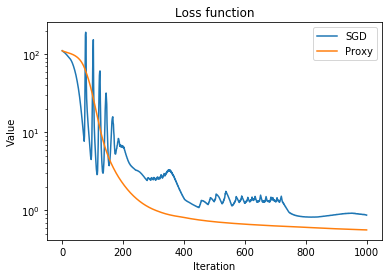

In [20]:
plt.plot(output_SGD, label='SGD')
plt.plot(output_FBSNN, label='Proxy')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Loss function')
plt.legend()
plt.yscale('log')